In [1]:
library(performance)
library(ggplot2)
library(dplyr)
library(rstatix)
library(ggpubr)
library(cluster)


Warning message:
“package ‘performance’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘rstatix’ was built under R version 4.3.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘cluster’ was built under R version 4.3.3”


# Reading Data

In [2]:
df<-read.csv("../Figure4/04_Durability_Grouping_HAI_MSD//lm_res.csv")

In [3]:
HAI<-read.csv("../Figure4/03_Reponse_Grouping_HAI_MSD/HAI_Plotting.csv")

In [4]:
HAI_subet<-HAI %>% filter(Assay=="Flu B/Phuket HA",Flu_Year=="2020-2021")

In [5]:
HAI_subet<-left_join(HAI_subet,df,by=c("subjectGuid","Assay","Flu_Year"))

In [6]:
HAI_subet$Group <- paste0(HAI_subet$`Age.Group`, "_", HAI_subet$Flu_Day)
HAI_subet$Group <- factor(HAI_subet$Group, levels = c(
    "Young_Day_0", "Young_Day_7", "Young_Day_90", 
    "Older_Day_0", "Older_Day_7","Older_Day_90"))

In [7]:
df_max <- HAI_subet %>%
    arrange(responder) %>%
    group_by(Flu_Year) %>%
    summarise(max_overall = max(Adjusted_HAI.Mean_Perc_Inhib), .groups = "drop")

In [8]:
HAI_subet <-HAI_subet %>% mutate(responder=case_when(responder=="low responder"~"Lower Sustainer",
                                                   responder=="high responder"~"Higher Sustainer",
                                                   TRUE~"Middle Sustainer"))
HAI_subet$responder <- factor(HAI_subet$responder, levels = c("Lower Sustainer","Middle Sustainer", "Higher Sustainer"))

In [9]:

create_comp <- function(groups, multiplier, paired,df) {
    res <- if (paired) {
        compare_means(Adjusted_HAI.Mean_Perc_Inhib ~ Group, data = df %>%
            filter(Group %in% groups) %>%
            arrange(subjectGuid, Group), method = "wilcox.test", paired = TRUE, paired_by = "subject.subjectGuid", comparisons = list(groups), group.by = c(
            "responder","Flu_Year"))
    } else {
        compare_means(Adjusted_HAI.Mean_Perc_Inhib ~ Group, data = df %>%
            filter(Group %in% groups) %>%
            arrange(subjectGuid, Group), method = "wilcox.test", paired = FALSE, comparisons = list(groups), group.by = c("responder", "Flu_Year"))
    }

    res %>%
        left_join(df_max ) %>%
        mutate(y.position = max_overall * multiplier)
}

In [10]:
comp_list <- list(
    create_comp(c("Older_Day_7", "Older_Day_90"), 1.05, TRUE,df=HAI_subet), 
    create_comp(c("Young_Day_7", "Young_Day_90"), 1.05, TRUE,df=HAI_subet)
)

comp_all <- bind_rows(comp_list)

Joining with `by = join_by(Flu_Year)`
Joining with `by = join_by(Flu_Year)`


In [12]:
write.csv(HAI_subet %>% select(subjectGuid,Assay,Flu_Year,Flu_Day,Group,Adjusted_HAI.Mean_Perc_Inhib),
          "/home//workspace/Source_Data/Extended_Fig5f.csv", 
          row.names=FALSE)

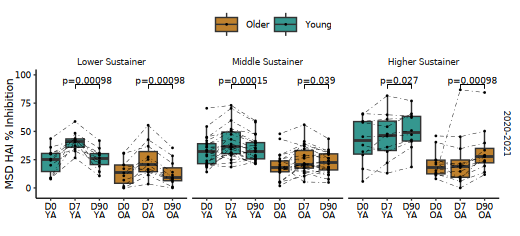

In [14]:
comp_all$p.label <- paste0("p=", comp_all$p.format)
comp_all <- comp_all %>%
  mutate(
    p.label = paste0("p=", signif(p, 2))
  )

p <- ggplot(HAI_subet %>%
    arrange(subjectGuid, Flu_Day), aes(x = Group, y = Adjusted_HAI.Mean_Perc_Inhib, fill = `Age.Group`)) +
    geom_boxplot(outlier.shape = NA, lwd = 0.3) +
    geom_point(color = "black", size = 0.5, stroke = 0) +
    theme_classic(base_size = 6) +
    scale_fill_manual(values = c(Older = "#bf812d", 
                                 Young = "#35978f")) +
    scale_y_continuous(expand = expansion(mult = c(0.1, 0.15))) +
    xlab("") +
    ylab("MSD HAI % Inhibition")  +
    scale_x_discrete(labels = c(
        Older_Day_0 = "D0\nOA",
        Older_Day_7 = "D7\nOA", 
        Older_Day_90 = "D90\nOA", 
        Young_Day_0 = "D0\nYA", 
        Young_Day_7 = "D7\nYA", 
        Young_Day_90 = "D90\nYA"
    )) +
    theme(
        legend.position = "top", legend.title = element_blank(), axis.line = element_line(colour = "black"), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.border = element_blank(), panel.background = element_blank(), 
        strip.background = element_rect(linewidth = 0), 
        axis.title.x = element_text(margin = margin(t = 1))
    ) +
    geom_line(aes(group = interaction(`Age.Group`, subjectGuid)), color = "black", linewidth = 0.1, linetype = 4) +
    facet_grid(Flu_Year ~ responder) +
    stat_pvalue_manual(comp_all, label = "p.label", 
                       size = 1.76, bracket.size = 0.2,
                       inherit.aes = FALSE)+ theme(
  axis.title   = element_text(color = "black"),
  axis.text    = element_text(color = "black")
)

options(repr.plot.width = 110/25.4, repr.plot.height = 50/25.4)

p

ggsave('FigureF.pdf', p, width = 115/25.4, height = 50/25.4)